In [1]:
import tensorflow as tf
print(tf.keras.__version__)

2024-07-02 14:19:48.131642: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-02 14:19:48.180379: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-02 14:19:48.180421: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-02 14:19:48.184303: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-02 14:19:48.196438: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-02 14:19:48.197051: I tensorflow/core/platform/cpu_feature_guard.cc:1

3.4.1


In [2]:
physical_devices = tf.config.list_physical_devices('XPU')
physical_devices

[PhysicalDevice(name='/physical_device:XPU:0', device_type='XPU')]

In [3]:
#Prep the notebook
#import necessary sources 
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import pandas as pd
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir, make_confusion_matrix, compare_historys
from sklearn.metrics import accuracy_score


#inspect the dataset directory
walk_through_dir("black_garlic_50_test")

# Create training and test directories
train_dir = "black_garlic_50_test/train/"
test_dir = "black_garlic_50_test/test/"

# Create data inputs
IMG_SIZE = (224, 224) # define image size
train_data_50_test = keras.utils.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # what type are the labels?
                                                                            batch_size=32) # batch_size is 32 by default, this is generally a good number
test_data_50_test = keras.utils.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical",
                                                                           batch_size=32,
                                                                           shuffle=False)
val_data_50_test = keras.utils.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=32,
                                                                           label_mode="categorical",
                                                                           shuffle=True)


There are 2 directories and 0 images in 'black_garlic_50_test'.
There are 3 directories and 0 images in 'black_garlic_50_test/train'.
There are 0 directories and 816 images in 'black_garlic_50_test/train/underaged'.
There are 0 directories and 816 images in 'black_garlic_50_test/train/overaged'.
There are 0 directories and 816 images in 'black_garlic_50_test/train/excellent'.
There are 3 directories and 0 images in 'black_garlic_50_test/test'.
There are 0 directories and 94 images in 'black_garlic_50_test/test/underaged'.
There are 0 directories and 94 images in 'black_garlic_50_test/test/overaged'.
There are 0 directories and 94 images in 'black_garlic_50_test/test/excellent'.
Found 1224 files belonging to 3 classes.


2024-07-02 14:19:50.725214: I tensorflow/core/common_runtime/next_pluggable_device/next_pluggable_device_factory.cc:118] Created 1 TensorFlow NextPluggableDevices. Physical device type: XPU


Found 141 files belonging to 3 classes.
Found 141 files belonging to 3 classes.


In [4]:
#Script to generate important details and figures
def generate_details(model,test_data,history):
    print("Evaluating...")
    loaded_loss, loaded_accuracy = model.evaluate(test_data)
    loaded_loss, loaded_accuracy
    print("done.")
    #make predictions usind the model
    print("Predicting...")
    pred_probs = model.predict(test_data, verbose=1) # set verbosity to see how long it will take
    print("done.")
    
    # Get the class predicitons of each label
    pred_classes = pred_probs.argmax(axis=1)
    
    # How do they look?
    pred_classes[:10]
    
    # make labels using unbatch
    y_labels = []
    for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
      y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
    y_labels[:10] # check what they look like (unshuffled)
    
    # Get accuracy score by comparing predicted classes to ground truth labels
    sklearn_accuracy = accuracy_score(y_labels, pred_classes)
    sklearn_accuracy
    
    # Does the evaluate method compare to the Scikit-Learn measured accuracy?
    import numpy as np
    print(f"Close? {np.isclose(loaded_accuracy, sklearn_accuracy)} | Difference: {loaded_accuracy - sklearn_accuracy}")
    
    # Get the class names
    class_names = test_data.class_names
    class_names[:10]
    
    #Plot the curves
    plot_loss_curves(history,figsize=(6, 3))
    
    #Genrate the confusion matrix
    make_confusion_matrix(y_true=y_labels,
                          y_pred=pred_classes,
                          classes=class_names,
                          figsize=(5, 5),
                          text_size=10,
                          norm=True,#with percentage
                          savefig=True)

In [5]:
def plot_loss_curves(history,figsize=(8, 8)):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.figure(figsize=figsize)
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure(figsize=figsize)
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [6]:
# Setup checkpoint path

def setup_checkpoint(model_name):
    checkpoint_path = "checkpoints/"+model_name+".ckpt" 
    
    # Create a ModelCheckpoint callback that saves the model's weights only
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                             save_weights_only=True, # set to False to save the entire model
                                                             save_best_only=True, # save only the best model weights instead of a model every epoch
                                                             save_freq="epoch", # save every epoch
                                                             verbose=1)
    return checkpoint_callback

In [7]:
res=[]
def gen_evaluation(model,test_data):
    loss, accuracy = model.evaluate(test_data)
    res.append([model.name,loss*100,accuracy*100])
    
def show_results(results):
    all_results = pd.DataFrame(results, columns=["Model", "Loss", "Accuracy"])
    return all_results

In [8]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNetV2 inputs don't have to be normalized)
x = base_model(inputs)

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(3, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_1 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_1.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"],
              jit_compile = False)
              
model_1.name="Model_1_EfficientNetB0"

#setup checkpoint
#ckpt = setup_checkpoint("model_1")

# 10. Fit the model (we use less steps for validation so it's faster)
history1 = model_1.fit(train_data_50_test,
                       epochs=10,
                       validation_data=val_data_50_test,
                       #validation_steps=int(1 * len(val_data_50_test)),
                       #callbacks=[ckpt]
                      )

Epoch 1/10


2024-07-02 14:19:55.350307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type XPU is enabled.


39/39 ━━━━━━━━━━━━━━━━━━━━ 18s 256ms/step - accuracy: 0.5992 - loss: 0.9446 - val_accuracy: 0.8014 - val_loss: 0.5873
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 178ms/step - accuracy: 0.8310 - loss: 0.5836 - val_accuracy: 0.9149 - val_loss: 0.3976
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 179ms/step - accuracy: 0.9128 - loss: 0.4207 - val_accuracy: 0.9574 - val_loss: 0.3222
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 176ms/step - accuracy: 0.9328 - loss: 0.3284 - val_accuracy: 0.9645 - val_loss: 0.2617
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 182ms/step - accuracy: 0.9313 - loss: 0.3039 - val_accuracy: 0.9645 - val_loss: 0.2308
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 189ms/step - accuracy: 0.9303 - loss: 0.2712 - val_accuracy: 0.9574 - val_loss: 0.2156
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 185ms/step - accuracy: 0.9429 - loss: 0.2305 - val_accuracy: 0.9645 - val_loss: 0.1853
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 189ms/step - accuracy: 0.9529 - loss: 0.2124 - val_accuracy: 0.9645 - val

In [9]:
gen_evaluation(model_1,test_data_50_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.9782 - loss: 0.1310


Evaluating...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.9782 - loss: 0.1310
done.
Predicting...
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 361ms/step
done.
Close? True | Difference: -1.5640935102645415e-08


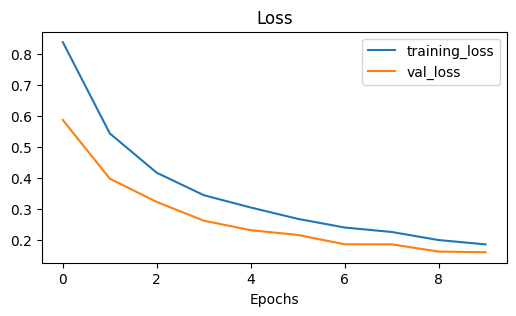

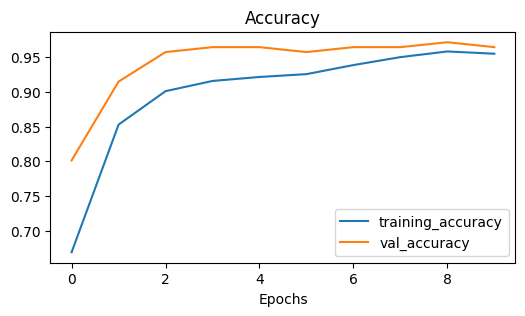

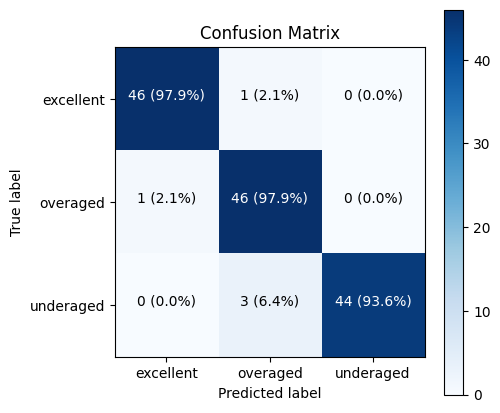

In [10]:
#Generate needed details
generate_details(model_1,test_data_50_test,history1)

In [11]:
#Model 1 EfficientNetB0 with fine-tuning

In [12]:

# 2. Make last 10 layers trainable at slower rate
model_1.layers[1].trainable = True

# Freeze all layers except for the last 10
for layer in model_1.layers[1].layers[:-10]:
  layer.trainable = False

# 9. Compile the model
model_1.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #set lower training rate
              metrics=["accuracy"],
              jit_compile = False)

# 10. Fit the model (we use less steps for validation so it's faster)
initial_epochs = 10
fine_tune_epochs = initial_epochs + 10

model_1.name="Model_1_EfficientNetB0_with_fine-tuning"

history1_tuned = model_1.fit(train_data_50_test,
                             epochs=fine_tune_epochs,
                             validation_data=val_data_50_test,
                             initial_epoch=history1.epoch[-1], 
                            )

Epoch 10/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 16s 233ms/step - accuracy: 0.9423 - loss: 0.2117 - val_accuracy: 0.9787 - val_loss: 0.1151
Epoch 11/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - accuracy: 0.9602 - loss: 0.1443 - val_accuracy: 0.9858 - val_loss: 0.0967
Epoch 12/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 192ms/step - accuracy: 0.9709 - loss: 0.1244 - val_accuracy: 0.9716 - val_loss: 0.0977
Epoch 13/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 197ms/step - accuracy: 0.9723 - loss: 0.1090 - val_accuracy: 0.9787 - val_loss: 0.0863
Epoch 14/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step - accuracy: 0.9756 - loss: 0.0882 - val_accuracy: 0.9716 - val_loss: 0.0717
Epoch 15/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 195ms/step - accuracy: 0.9798 - loss: 0.0747 - val_accuracy: 0.9858 - val_loss: 0.0650
Epoch 16/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - accuracy: 0.9736 - loss: 0.0781 - val_accuracy: 0.9858 - val_loss: 0.0585
Epoch 17/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 195ms/step - accuracy: 0.9847 - loss: 0.0636 - val_acc

In [13]:
gen_evaluation(model_1,test_data_50_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.9920 - loss: 0.0391


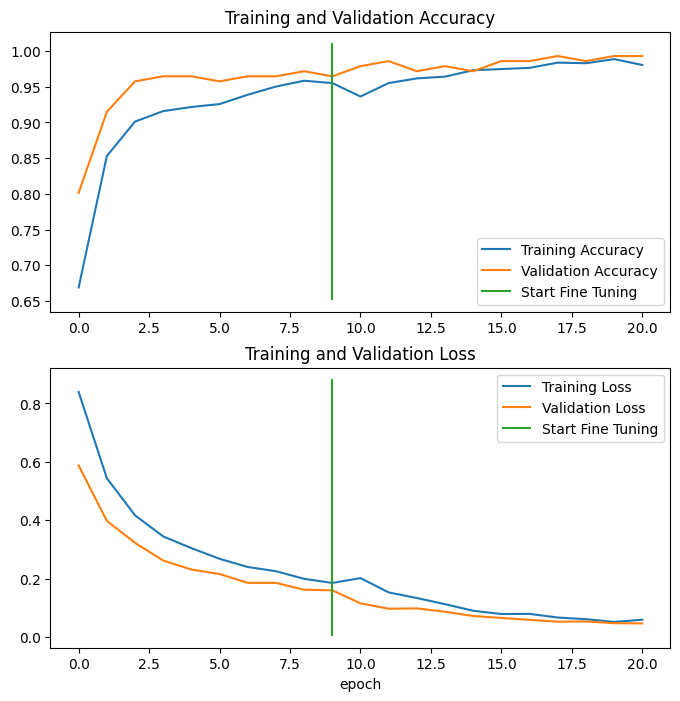

In [14]:
compare_historys(original_history=history1,
                 new_history=history1_tuned,
                 initial_epochs=10)

In [15]:
# Model 2 EfficientNetB0 with augmentation

In [16]:
import keras
from keras import layers

# NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = keras.Sequential([
  layers.RandomZoom(0.1,0.3),
  layers.RandomFlip("horizontal"),
], name ="data_augmentation")


# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(3, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
model_2 = keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"],
              jit_compile = False)

model_2.name="Model_2_EfficientNetB0_with_augmentation"

# Fit the model
history2 = model_2.fit(train_data_50_test,
                       epochs=10,
                       validation_data=val_data_50_test,
                      )

Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 16s 229ms/step - accuracy: 0.4733 - loss: 1.0049 - val_accuracy: 0.7234 - val_loss: 0.6814
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 198ms/step - accuracy: 0.7818 - loss: 0.6716 - val_accuracy: 0.8369 - val_loss: 0.4996
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 193ms/step - accuracy: 0.8426 - loss: 0.5313 - val_accuracy: 0.8794 - val_loss: 0.4182
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 198ms/step - accuracy: 0.8940 - loss: 0.4192 - val_accuracy: 0.8794 - val_loss: 0.3607
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - accuracy: 0.9075 - loss: 0.3891 - val_accuracy: 0.8865 - val_loss: 0.3300
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 195ms/step - accuracy: 0.9162 - loss: 0.3592 - val_accuracy: 0.9007 - val_loss: 0.2983
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 200ms/step - accuracy: 0.9189 - loss: 0.3290 - val_accuracy: 0.9149 - val_loss: 0.2774
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 198ms/step - accuracy: 0.9174 - loss: 0.3020 - val_accuracy: 0

In [17]:
gen_evaluation(model_2,test_data_50_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.9439 - loss: 0.1772


Evaluating...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9439 - loss: 0.1772
done.
Predicting...
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 364ms/step
done.
Close? True | Difference: -4.945917331244942e-08


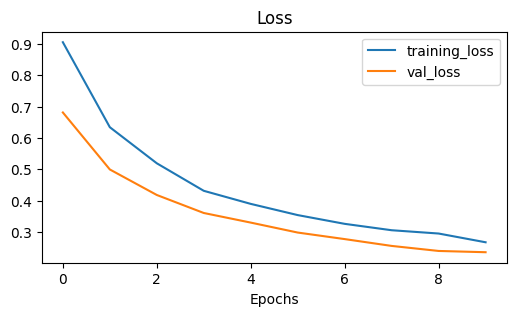

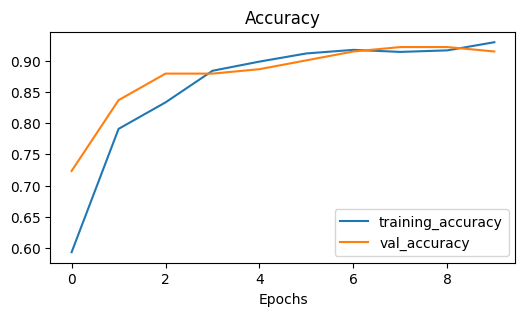

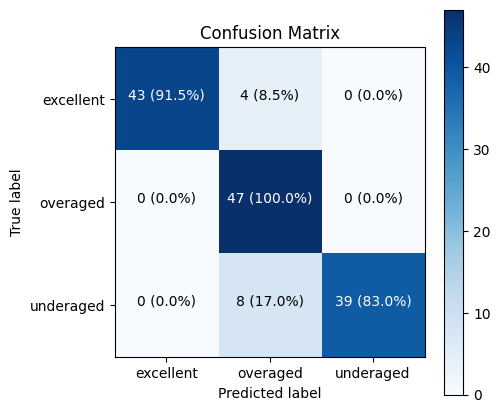

In [18]:
#Generate needed details
generate_details(model_2,test_data_50_test,history2)

In [19]:
# Model 2 EfficientNetB0 with augmentation and fine-tuning

In [20]:
# 1. Access the base model to fine tune
#model_2_base_model = model_2.layers[2]

# 2. Make last 10 layers trainable at slower rate
model_2.layers[2].trainable = True


# Freeze all layers except for the last 10
for layer in model_2.layers[2].layers[:-10]:
  layer.trainable = False

# 9. Compile the model
model_2.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #set lower training rate
              metrics=["accuracy"],
              jit_compile = False)

model_2.name = "Model_2_EfficientNetB0_with_augmentation_and_fine-tuning"

# 10. Fit the model (we use less steps for validation so it's faster)
initial_epochs = 10
fine_tune_epochs = initial_epochs + 10

history2_tuned = model_2.fit(train_data_50_test,
                                 epochs=fine_tune_epochs,
                                 #steps_per_epoch=len(train_data_50_test),
                                 validation_data=val_data_50_test,
                                 initial_epoch=history2.epoch[-1]
                            )

Epoch 10/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 17s 250ms/step - accuracy: 0.8875 - loss: 0.3093 - val_accuracy: 0.9149 - val_loss: 0.2399
Epoch 11/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 214ms/step - accuracy: 0.9448 - loss: 0.1972 - val_accuracy: 0.9362 - val_loss: 0.1933
Epoch 12/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 211ms/step - accuracy: 0.9552 - loss: 0.1738 - val_accuracy: 0.9433 - val_loss: 0.1644
Epoch 13/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 216ms/step - accuracy: 0.9476 - loss: 0.1555 - val_accuracy: 0.9433 - val_loss: 0.1564
Epoch 14/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 222ms/step - accuracy: 0.9608 - loss: 0.1295 - val_accuracy: 0.9433 - val_loss: 0.1435
Epoch 15/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 213ms/step - accuracy: 0.9684 - loss: 0.1257 - val_accuracy: 0.9291 - val_loss: 0.1555
Epoch 16/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 211ms/step - accuracy: 0.9596 - loss: 0.1199 - val_accuracy: 0.9362 - val_loss: 0.1622
Epoch 17/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 213ms/step - accuracy: 0.9579 - loss: 0.1189 - val_acc

In [21]:
gen_evaluation(model_2,test_data_50_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9693 - loss: 0.0835


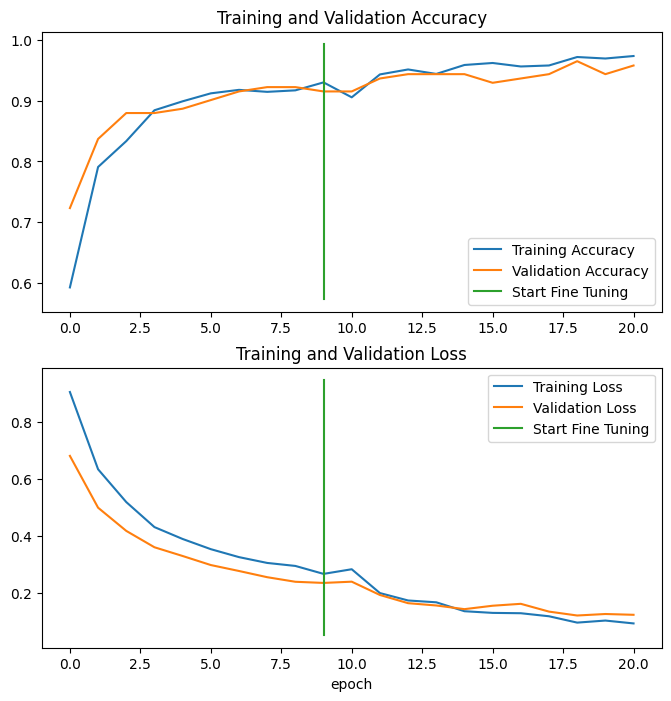

In [22]:
compare_historys(original_history=history2,
                 new_history=history2_tuned,
                 initial_epochs=10)

In [23]:
# Model 3 ResNet50v2

In [24]:

# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.ResNet50V2(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNetV2
x = tf.keras.layers.Rescaling(1./255,name="rescaler")(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNetV2 inputs don't have to be normalized)
x = base_model(x)

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# add dropout to further reduce overfitting
x = tf.keras.layers.Dropout(0.2)(x)

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(3, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_3 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_3.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"],
              jit_compile = False)
model_3.name = "Model_3_ResNet50v2"

# 10. Fit the model (we use less steps for validation so it's faster)
history3 = model_3.fit(train_data_50_test,
                       epochs=10,
                       #steps_per_epoch=len(train_data_50_test),
                       validation_data=val_data_50_test,
                       #validation_steps=int(0.5 * len(val_data_50_test))
                      )

Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step - accuracy: 0.3936 - loss: 1.4560 - val_accuracy: 0.7163 - val_loss: 0.6744
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.6907 - loss: 0.6952 - val_accuracy: 0.8085 - val_loss: 0.4644
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.8135 - loss: 0.4811 - val_accuracy: 0.9220 - val_loss: 0.3370
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.8687 - loss: 0.3780 - val_accuracy: 0.8865 - val_loss: 0.3054
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.8993 - loss: 0.3171 - val_accuracy: 0.8794 - val_loss: 0.3178
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.8894 - loss: 0.3241 - val_accuracy: 0.9291 - val_loss: 0.2620
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.8928 - loss: 0.2923 - val_accuracy: 0.9362 - val_loss: 0.2193
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.9276 - loss: 0.2248 - val_accuracy: 0

In [25]:
gen_evaluation(model_3,test_data_50_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.9276 - loss: 0.1912


Evaluating...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.9276 - loss: 0.1912
done.
Predicting...
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7fbfa22b1dc0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 284ms/step
done.
Close? True | Difference: -1.0568199426685965e-08


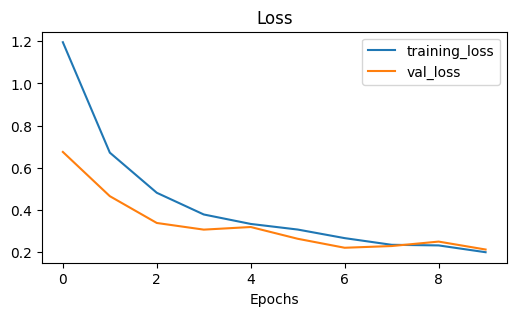

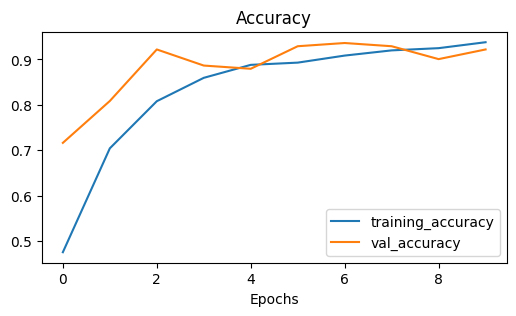

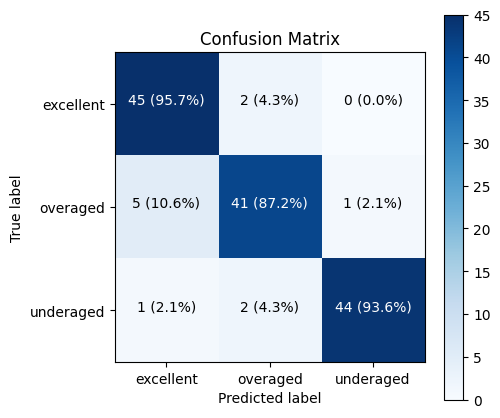

In [26]:
#Generate needed details
generate_details(model_3,test_data_50_test,history3)

In [27]:
# Model 3 ResNet50v2 with fine-tuning

In [28]:
# 1. Access the base model to fine tune
#model_3_base_model = model_3.layers[1]

# 2. Make last 10 layers trainable at slower rate
model_3.layers[2].trainable = True

# Freeze all layers except for the last 10
for layer in model_3.layers[2].layers[:-10]:
  layer.trainable = False

# 9. Compile the model
model_3.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #set lower training rate 0.001 is default
              metrics=["accuracy"],
              jit_compile = False)

model_3.name = "Model_3_ResNet50v2_with_fine-tuning"

# 10. Fit the model (we use less steps for validation so it's faster)
initial_epochs = 10
fine_tune_epochs = initial_epochs + 10

history3_tuned = model_3.fit(train_data_50_test,
                                 epochs=fine_tune_epochs,
                                 #steps_per_epoch=len(train_data_50_test),
                                 validation_data=val_data_50_test,
                                 initial_epoch=history3.epoch[-1], # start from previous last epoch
                            )

Epoch 10/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - accuracy: 0.8949 - loss: 0.2909 - val_accuracy: 0.9149 - val_loss: 0.1545
Epoch 11/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 0.9695 - loss: 0.0809 - val_accuracy: 0.9362 - val_loss: 0.1304
Epoch 12/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.9984 - loss: 0.0273 - val_accuracy: 0.9787 - val_loss: 0.0750
Epoch 13/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.9974 - loss: 0.0162 - val_accuracy: 0.9574 - val_loss: 0.1067
Epoch 14/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 0.9971 - loss: 0.0119 - val_accuracy: 0.9645 - val_loss: 0.0984
Epoch 15/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.9988 - loss: 0.0092 - val_accuracy: 0.9504 - val_loss: 0.1485
Epoch 16/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 0.0084 - val_accuracy: 0.9645 - val_loss: 0.1126
Epoch 17/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.9945 - loss: 0.0142 - val_acc

In [29]:
gen_evaluation(model_3,test_data_50_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.9685 - loss: 0.0796


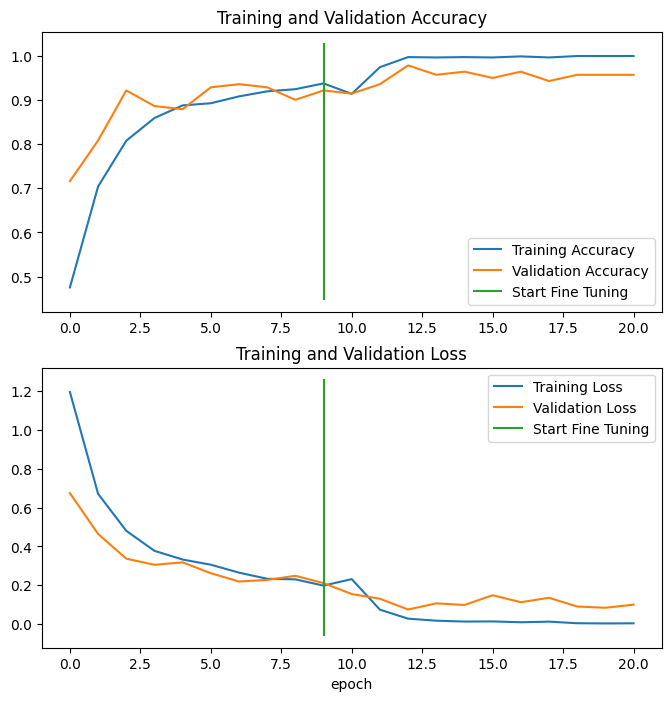

In [30]:
compare_historys(original_history=history3,
                 new_history=history3_tuned,
                 initial_epochs=10)

In [31]:
# Model 4 ResNet50v2 with augmentation

In [32]:
import keras
from keras import layers

data_augmentation = keras.Sequential([
  layers.RandomZoom(0.1,0.3),
  layers.RandomFlip("horizontal"),
  layers.Rescaling(1./255)
], name ="data_augmentation")

# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.ResNet50V2(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# add drop layer
x = layers.Dropout(0.2)(x)

# Put a dense layer on as the output
outputs = layers.Dense(3, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
model_4 = keras.Model(inputs, outputs)

# Compile the model
model_4.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"],
              jit_compile = False)

model_4.name = "Model_4_ResNet50v2_with_augmentation"

# Fit the model
history4 = model_4.fit(train_data_50_test,
                       epochs=10,
                       validation_data=val_data_50_test
                      )

Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - accuracy: 0.4335 - loss: 1.3680 - val_accuracy: 0.6667 - val_loss: 0.7459
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.6587 - loss: 0.7710 - val_accuracy: 0.7943 - val_loss: 0.5206
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.7422 - loss: 0.6205 - val_accuracy: 0.8652 - val_loss: 0.4148
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.8263 - loss: 0.4466 - val_accuracy: 0.9078 - val_loss: 0.3306
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 0.8304 - loss: 0.4464 - val_accuracy: 0.8723 - val_loss: 0.3398
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.8535 - loss: 0.3848 - val_accuracy: 0.8723 - val_loss: 0.3122
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.8669 - loss: 0.3389 - val_accuracy: 0.8794 - val_loss: 0.3064
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.8909 - loss: 0.3135 - val_accuracy: 0

In [33]:
gen_evaluation(model_4,test_data_50_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9291 - loss: 0.2239


Evaluating...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.9291 - loss: 0.2239
done.
Predicting...
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 289ms/step
done.
Close? True | Difference: -8.031831533195088e-09


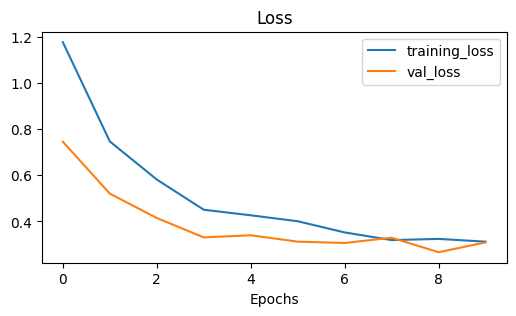

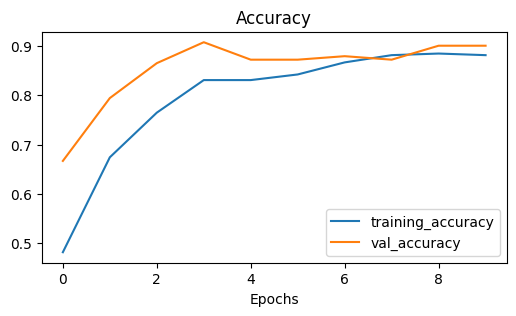

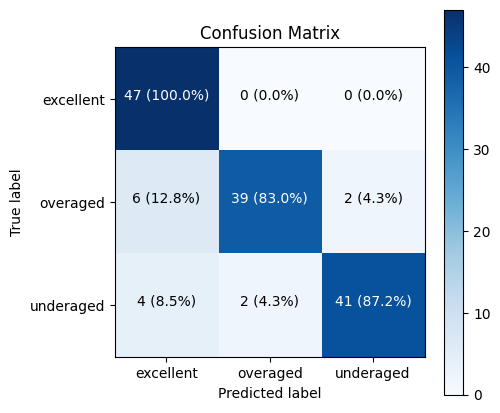

In [34]:
#Generate needed details
generate_details(model_4,test_data_50_test,history4)

In [35]:
# Model 4 ResNet50v2 with augmentation with fine-tuning

In [36]:
# 1. Access the base model to fine tune
#model_4_base_model = model_4.layers[2]

# 2. Make last 10 layers trainable at slower rate
model_4.layers[2].trainable = True

# Freeze all layers except for the last 10
for layer in model_4.layers[2].layers[:-10]:
  layer.trainable = False

# 9. Compile the model
model_4.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #set lower training rate
              metrics=["accuracy"],
              jit_compile = False)

model_4.name = "Model_4_ResNet50v2_with_augmentation_with_fine-tuning"

# 10. Fit the model (we use less steps for validation so it's faster)
initial_epochs = 10
fine_tune_epochs = initial_epochs + 10

history4_tuned = model_4.fit(train_data_50_test,
                                 epochs=fine_tune_epochs,
                                 #steps_per_epoch=len(train_data_50_test),
                                 validation_data=val_data_50_test,
                                 initial_epoch=history4.epoch[-1],
                            )

Epoch 10/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 183ms/step - accuracy: 0.8286 - loss: 0.4169 - val_accuracy: 0.7589 - val_loss: 0.6362
Epoch 11/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 0.9175 - loss: 0.2159 - val_accuracy: 0.9220 - val_loss: 0.2661
Epoch 12/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - accuracy: 0.9649 - loss: 0.1295 - val_accuracy: 0.9078 - val_loss: 0.2151
Epoch 13/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.9814 - loss: 0.0912 - val_accuracy: 0.9149 - val_loss: 0.2198
Epoch 14/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 0.9639 - loss: 0.0977 - val_accuracy: 0.9220 - val_loss: 0.2034
Epoch 15/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 0.9800 - loss: 0.0699 - val_accuracy: 0.9007 - val_loss: 0.2074
Epoch 16/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - accuracy: 0.9709 - loss: 0.0723 - val_accuracy: 0.9504 - val_loss: 0.1551
Epoch 17/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 0.9833 - loss: 0.0551 - val_acc

In [37]:
gen_evaluation(model_4,test_data_50_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.9434 - loss: 0.1505


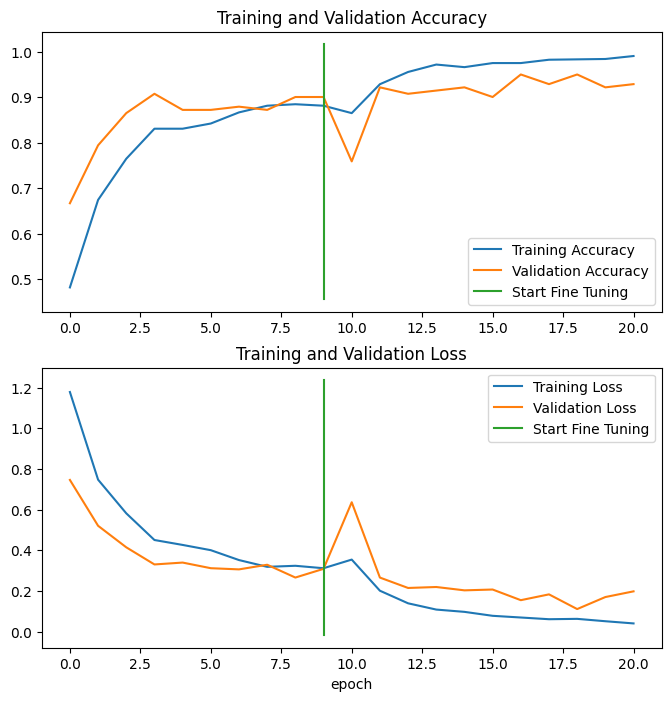

In [38]:
compare_historys(original_history=history4,
                 new_history=history4_tuned,
                 initial_epochs=10)

In [39]:
# Model 5 VGG16

In [40]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.VGG16(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNetV2
x = tf.keras.layers.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNetV2 inputs don't have to be normalized)
x = base_model(x)
# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(3, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_5 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_5.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"],
              jit_compile = False)

model_5.name = "Model_5_VGG16"

# 10. Fit the model (we use less steps for validation so it's faster)
history5 = model_5.fit(train_data_50_test,
                       epochs=10,
                       validation_data=val_data_50_test
                      )

Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.3428 - loss: 1.3826 - val_accuracy: 0.4043 - val_loss: 1.1079
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.3203 - loss: 1.1053 - val_accuracy: 0.3617 - val_loss: 1.0857
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.4125 - loss: 1.0820 - val_accuracy: 0.3972 - val_loss: 1.0745
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.4619 - loss: 1.0723 - val_accuracy: 0.5390 - val_loss: 1.0591
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.4929 - loss: 1.0565 - val_accuracy: 0.5248 - val_loss: 1.0489
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.5349 - loss: 1.0427 - val_accuracy: 0.5461 - val_loss: 1.0368
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.5249 - loss: 1.0339 - val_accuracy: 0.5248 - val_loss: 1.0245
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.5668 - loss: 1.0221 - val_accuracy: 0.

In [41]:
gen_evaluation(model_5,test_data_50_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.7116 - loss: 0.9706


Evaluating...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.7116 - loss: 0.9706 
done.
Predicting...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step
done.
Close? True | Difference: -1.9022758923625815e-08


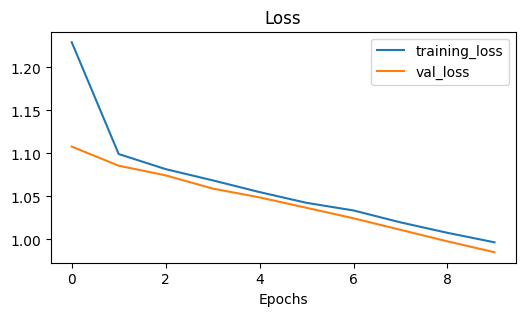

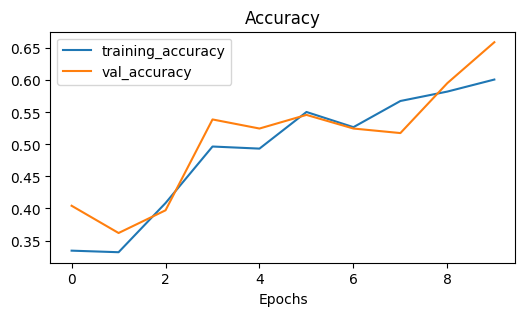

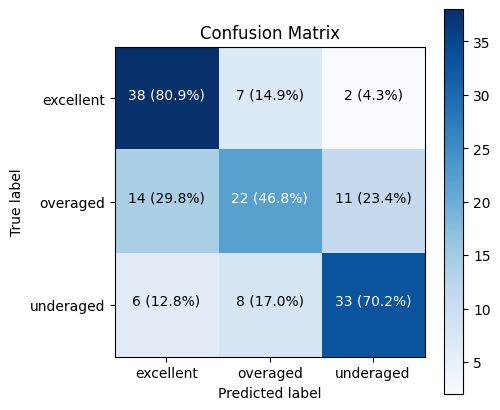

In [42]:
#Generate needed details
generate_details(model_5,test_data_50_test,history5)

In [43]:
# Model 5 VGG16 with fine-tuning

In [44]:
# 1. Access the base model to fine tune
#model_5_base_model = model_5.layers[1]

# 2. Make last 10 layers trainable at slower rate
model_5.layers[2].trainable = True

# Freeze all layers except for the last 10
for layer in model_5.layers[2].layers[:-3]:
  layer.trainable = False

# 9. Compile the model
model_5.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00007), #set lower training rate 0.001 is default
              metrics=["accuracy"],
              jit_compile = False)

model_5.name = "Model_5_VGG16_with_fine-tuning"

# 10. Fit the model (we use less steps for validation so it's faster)
initial_epochs = 10
fine_tune_epochs = initial_epochs + 10

history5_tuned = model_5.fit(train_data_50_test,
                                 epochs=fine_tune_epochs,
                                 validation_data=val_data_50_test,
                                 initial_epoch=history5.epoch[-1])

Epoch 10/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 0.6384 - loss: 0.8685 - val_accuracy: 0.7234 - val_loss: 0.6565
Epoch 11/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.7839 - loss: 0.5415 - val_accuracy: 0.8794 - val_loss: 0.3929
Epoch 12/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.8877 - loss: 0.3396 - val_accuracy: 0.8652 - val_loss: 0.3493
Epoch 13/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.9170 - loss: 0.2503 - val_accuracy: 0.9007 - val_loss: 0.3158
Epoch 14/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.9294 - loss: 0.2253 - val_accuracy: 0.9220 - val_loss: 0.2604
Epoch 15/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.9761 - loss: 0.1300 - val_accuracy: 0.9291 - val_loss: 0.2667
Epoch 16/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.9772 - loss: 0.1163 - val_accuracy: 0.9078 - val_loss: 0.2370
Epoch 17/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.9907 - loss: 0.0781 - val_accu

In [45]:
gen_evaluation(model_5,test_data_50_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9657 - loss: 0.1556


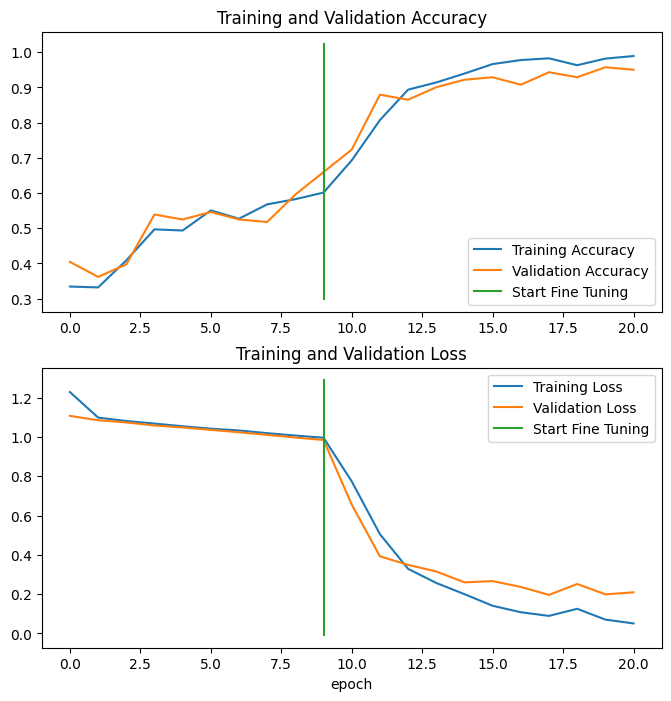

In [46]:
compare_historys(original_history=history5,
                 new_history=history5_tuned,
                 initial_epochs=10)

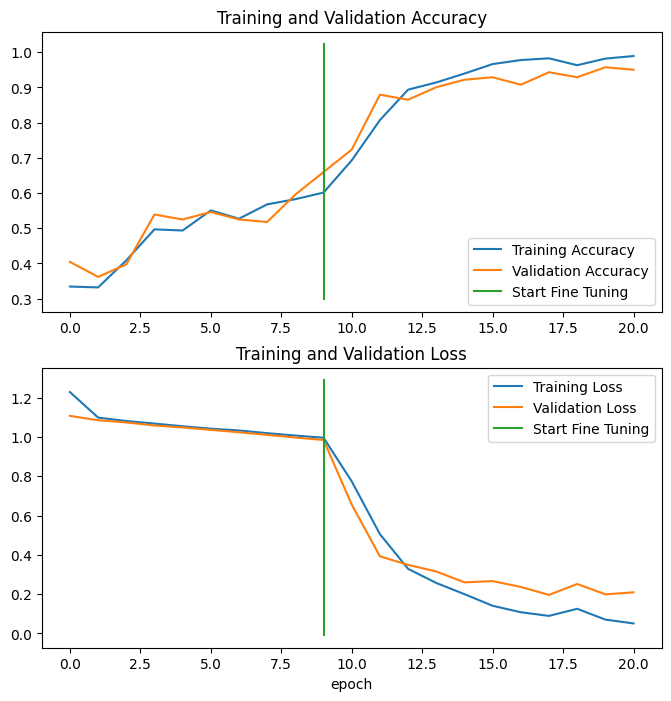

In [47]:
compare_historys(original_history=history5,
                 new_history=history5_tuned,
                 initial_epochs=10)

In [48]:
# Model 6 VGG16 with augmentation

In [49]:
import keras
from keras import layers

data_augmentation = keras.Sequential([
  layers.RandomZoom(0.1,0.3),
  layers.RandomFlip("horizontal"),
], name ="data_augmentation")


# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.VGG16(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

x = tf.keras.layers.Rescaling(1./255, name="rescaler")(x)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(3, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
model_6 = keras.Model(inputs, outputs)

# Compile the model
model_6.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"],
              jit_compile = False)

model_6.name = "Model_6_VGG16_with_augmentation"

# Fit the model
history6 = model_6.fit(train_data_50_test,
                       epochs=10,
                       validation_data=val_data_50_test
                      )

Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.3383 - loss: 1.2440 - val_accuracy: 0.5106 - val_loss: 1.0871
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 0.3817 - loss: 1.0868 - val_accuracy: 0.3972 - val_loss: 1.0707
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 0.3950 - loss: 1.0781 - val_accuracy: 0.4184 - val_loss: 1.0600
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - accuracy: 0.4096 - loss: 1.0691 - val_accuracy: 0.4255 - val_loss: 1.0485
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 0.5025 - loss: 1.0497 - val_accuracy: 0.4752 - val_loss: 1.0379
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - accuracy: 0.4725 - loss: 1.0433 - val_accuracy: 0.5177 - val_loss: 1.0253
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - accuracy: 0.4798 - loss: 1.0332 - val_accuracy: 0.5177 - val_loss: 1.0144
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 0.5368 - loss: 1.0224 - val_accuracy: 0.

In [50]:
gen_evaluation(model_6,test_data_50_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.4724 - loss: 1.0304


Evaluating...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.4724 - loss: 1.0304 
done.
Predicting...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
done.
Close? True | Difference: -4.52318935639795e-08


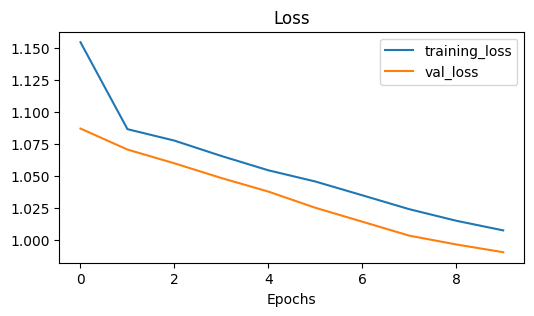

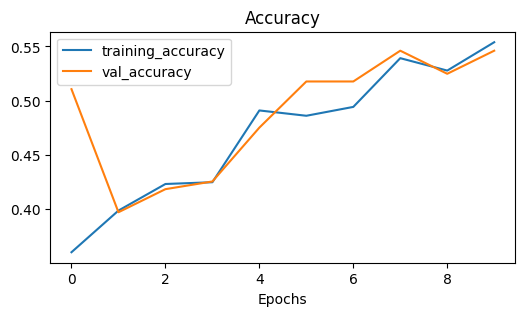

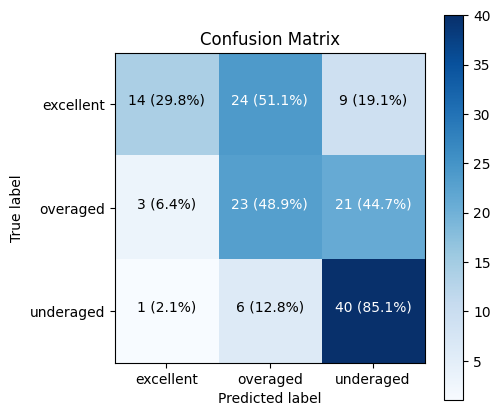

In [51]:
#Generate needed details
generate_details(model_6,test_data_50_test,history6)

In [52]:
# Model 6 VGG16 with augmentation and fine-tuning

In [53]:
# 1. Access the base model to fine tune
#model_6_base_model = model_6.layers[2]

# 2. Make last 10 layers trainable at slower rate
model_6.layers[3].trainable = True

# Freeze all layers except for the last 10
for layer in model_6.layers[3].layers[:-3]:
  layer.trainable = False

# 9. Compile the model
model_6.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00007), #set lower training rate
              metrics=["accuracy"])

model_6.name = "Model_6_VGG16_with_augmentation_and_fine-tuningn"

# 10. Fit the model (we use less steps for validation so it's faster)
initial_epochs = 10
fine_tune_epochs = initial_epochs + 10

history6_tuned = model_6.fit(train_data_50_test,
                                 epochs=fine_tune_epochs,
                                 validation_data=val_data_50_test,
                                 initial_epoch=history6.epoch[-1],
                            )

Epoch 10/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step - accuracy: 0.6067 - loss: 0.8947 - val_accuracy: 0.7021 - val_loss: 0.6612
Epoch 11/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 171ms/step - accuracy: 0.7453 - loss: 0.6273 - val_accuracy: 0.8794 - val_loss: 0.4250
Epoch 12/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - accuracy: 0.8012 - loss: 0.4991 - val_accuracy: 0.8369 - val_loss: 0.4152
Epoch 13/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 171ms/step - accuracy: 0.8751 - loss: 0.3517 - val_accuracy: 0.8865 - val_loss: 0.3382
Epoch 14/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step - accuracy: 0.8947 - loss: 0.3032 - val_accuracy: 0.8794 - val_loss: 0.3092
Epoch 15/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 166ms/step - accuracy: 0.9206 - loss: 0.2529 - val_accuracy: 0.8936 - val_loss: 0.2811
Epoch 16/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 171ms/step - accuracy: 0.9229 - loss: 0.2392 - val_accuracy: 0.8936 - val_loss: 0.2916
Epoch 17/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 167ms/step - accuracy: 0.9518 - loss: 0.1694 - val_accu

In [54]:
gen_evaluation(model_6,test_data_50_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.9418 - loss: 0.2315


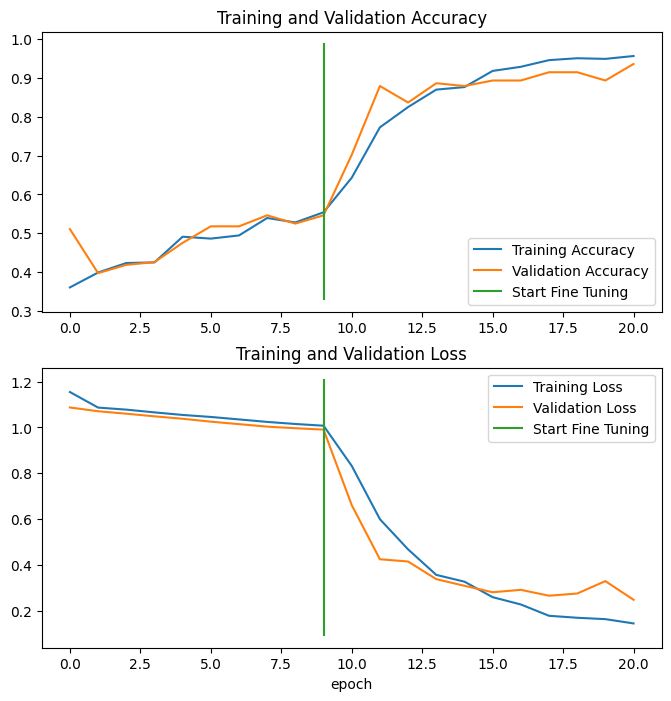

In [55]:
compare_historys(original_history=history6,
                 new_history=history6_tuned,
                 initial_epochs=10)

In [56]:

show_results(res)

,Model,Loss,Accuracy
0,Model_1_EfficientNetB0,15.960869,96.453899
1,Model_1_EfficientNetB0_with_fine-tuning,4.623108,99.290776
2,Model_2_EfficientNetB0_with_augmentation,23.554148,91.489357
3,Model_2_EfficientNetB0_with_augmentation_and_f...,12.368541,95.744675
4,Model_3_ResNet50v2,21.094988,92.198581
5,Model_3_ResNet50v2_with_fine-tuning,9.995966,95.744675
6,Model_4_ResNet50v2_with_augmentation,30.897313,90.070921
7,Model_4_ResNet50v2_with_augmentation_with_fine...,19.846310,92.907798
8,Model_5_VGG16,98.508859,65.957445
9,Model_5_VGG16_with_fine-tuning,20.946787,95.035458
